In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,emcee,corner,pidly
from my_script import best_fitting,run_myradex_of,mol_data,log_value,divation
from scipy.constants import h,k,c
from astropy import constants as const
from scipy.optimize import curve_fit

In [2]:
def compute_gasmass(NH2col,area):
    gasmass=NH2col*(2*1.66053904e-24)*area*3.08567758e18**2/1.98855e33 *dv #solar mass
    return gasmass
def compute_Ncol(nH2,abundance_Kvir):    
    Ncol=3.08e18*nH2*abundance_Kvir*1/(0.65*1.5**0.5*(nH2/1e3)**0.5)  #Papadopoulos et al. (2012)  Tunnard et al. (2015)
    return Ncol
def read_distance(sourcename):
    idx=np.where(basic_info[:,0]==sourcename)[0][0]
    d,r=float(basic_info[idx,4]),float(basic_info[idx,3])
    if not np.isnan(d):
        distance=d
    else:
        distance=r*c/1e3/67.8
    return distance
def read_redshift(sourcename):
    idx=np.where(basic_info[:,0]==sourcename)[0][0]
    d,r=float(basic_info[idx,4]),float(basic_info[idx,3])
    if not np.isnan(r):
        redshift=r
    else:
        redshift=d*67.8/c*1e3
    return redshift
def line_flux_lum(flux,frequency,redshift,distance):
    alpha=3.25e7/(frequency/1e9/(1+redshift))**2*distance**2/(1+redshift)**3
    lum=flux*np.array([alpha]).T
    return lum
def mcmc_fitting(xx,yy):
    xx_e,yy_e=xx,yy
    det_index=np.array([~np.isnan(xx_e[:,1])])
    N=len(xx_e[det_index[0],0])
    X=np.zeros([N,2])
    X[:,0]=xx_e[det_index[0],0]
    X[:,1]=yy_e[det_index[0],0]
    S=np.zeros([N,2,2])
    S[:,0,0]=xx_e[det_index[0],1]**2
    S[:,1,1]=yy_e[det_index[0],1]**2
    Sinv = np.array([np.linalg.inv(Sn) for Sn in S])
    
    def log_prior(params):
        m_tem = params[0]
        return -1.5 * np.log(1 + m_tem * m_tem)
    def log_prob_naive(params):
        m_tem, b_tem = params[:2]
        xhat = params[2:]
        yhat = m_tem * xhat + b_tem
        r = np.array(X)
        r[:, 0] -= xhat
        r[:, 1] -= yhat
        ll = -0.5 * np.einsum("n...i,nij,n...j", r, Sinv, r)
        return ll  + log_prior(params)

    nwalkers = 128
    xhat0 = np.array(X[:, 0])
    p0 = np.append([1,3], xhat0)
    p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
    sampler_naive = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_naive)
    pos, _, _ = sampler_naive.run_mcmc(p0, 5000)
    sampler_naive.reset()
    sampler_naive.run_mcmc(pos, 10000)
    samples_naive = sampler_naive.flatchain[:, :2]
    return samples_naive
def compute_dispersion(xx,yy,line_m,line_b):
    distances=(yy-line_m*xx-line_b)/np.sqrt(1+line_m**2)
    return np.mean(distances),np.std(distances)
def compute_coeff(xx,yy):
    result=np.zeros(16)
    mcmc=best_fitting(mcmc_fitting(xx,yy))
    result[0:3]=mcmc[0]
    result[3:6]=mcmc[1]
    ols=sixlin(xx,yy)
    result[6]=ols[0][3]
    result[7]=ols[2][3]
    result[8]=ols[1][3]
    result[9]=ols[3][3]
    coeff=np.ma.corrcoef(xx[:,0],yy[:,0])[0,1]
    scatter=compute_dispersion(xx[:,0],yy[:,0],ols[0][3],ols[1][3])
    result[10]=coeff
    result[11]=scatter[1]
    pearson=stats.pearsonr(xx[:,0],yy[:,0])
    result[12:14]=pearson[:]
    spearman=stats.spearmanr(xx[:,0],yy[:,0])
    result[14:16]=spearman[:]
    return result
# Planck et al. 2011b
def kappa_Planck(wl,b):
    return 1e-25*(wl/250)**(-b)/1.36/1.6606e-24          # Scoville et al. 2014
def kappa_Draine(wl,b):
    return 0.9764*(wl/500)**(-b)                         # https://www.astro.princeton.edu/~draine/dust/dustmix.html 
def kappa_Kovacs(wl,b):
    return 1.5*(wl/850)**(-b)                            # https://iopscience.iop.org/article/10.1088/0004-637X/717/1/29/pdf
def Bv(wl,T):
    v=c/wl*1e6
    term=np.exp(h*v/k/T)-1
    Iv=2*h*v**3/c**2/term*1e3                            # erg s^-1 cm^-2 Hz^-1 
    return Iv
def MBB_PISM(wl,Td,Mh,b,distance):
    M=Mh*1.989E33                                        # Msun -> g
    D=distance*3.08567758e24                             # Mpc -> cm
    Sv=kappa_Planck(wl,b)*M*Bv(wl,Td)/D**2*1e23                 # erg -> Jy
    return Sv
def MBB_Ddust(wl,Td,Md,b,distance):
    M=Md*1.989E33                                        # Msun -> g
    D=distance*3.08567758e24                             # Mpc -> cm
    Sv=kappa_Draine(wl,b)*M*Bv(wl,Td)/D**2*1e23                 # erg -> Jy
    return Sv
def Jy2lum(flux,distance):                               # https://iopscience.iop.org/article/10.1088/0004-637X/783/2/84/pdf
    return 1.19e27*flux*distance**2                      # erg s^-1 Hz^-1
def MBB_Kdust(wl,Td,Md,b,distance):
    M=Md*1.989E33                                        # Msun -> g
    D=distance*3.08567758e24                             # Mpc -> cm
    Sv=kappa_Kovacs(wl,b)*M*Bv(wl,Td)/D**2*1e23                 # erg -> Jy
    return Sv
10**8.1+10**5.4

126143729.82256757

In [3]:
basic_info=np.loadtxt('references/total_info_v2.csv',delimiter=',',dtype=str)
dv=300  #km/s
co_mol=mol_data('/home/zj/Documents/radex_mol/','co.dat')
muHe=1.36    # He correction, H2 -> molecular gas mass
def load_mol(molname,data):
    idx=np.where(data[0]==molname)[0][0]
    nline=len(np.where(data[1:,idx+1]!='')[0])
    Jup=np.arange(nline)+1
    SED=data[Jup,idx:idx+3].astype(float)
    return SED

### CO estimated mass ###

In [4]:
lg_MCOLVG=np.zeros([len(basic_info)-1,2])
def param_mass(lg_Tkin,lg_nH2,lg_Kvir,lg_size):
    area=np.pi/4/np.log(2)*(10**lg_size)**2
    Ncol=compute_Ncol(10**lg_nH2,1/10**lg_Kvir)
    lg_gasmass=np.log10(compute_gasmass(Ncol,area))
    return(lg_gasmass)
for i in range(1,len(basic_info)):
#for i in [103]:
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/CO_SLED/%s_samples.h5'%sourcename.replace(' ','')
    if not os.path.exists(sampfile):
        continue
    sampler = emcee.backends.HDFBackend(sampfile, read_only=True)
    samples=sampler.get_chain(discard=7000)
    if len(samples)!=13000:
        continue
    log_prob_samples = sampler.get_log_prob(discard=7000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    nparam=samples.shape[2]
    if nparam!=4:
        continue
    sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
    lg_gasmass=param_mass(sample_reshape[:,0],sample_reshape[:,1],sample_reshape[:,2],sample_reshape[:,3])
    max_gasmass=param_mass(*max_params)
    print(basic_info[i,0],max_params)
    dis_lggm=best_fitting(lg_gasmass)
    if (dis_lggm[2]-dis_lggm[1])/2<1:
        #fig=corner.corner(lg_gasmass,labels=[r'log $M_{\rm CO}~(\rm M_{\odot})$'])
        #plt.title(sourcename+' mass PDF')
        lg_MCOLVG[i-1]=[max_gasmass,(dis_lggm[2]-dis_lggm[1])/2]
lg_MCOLVG[lg_MCOLVG==0]=np.nan
lg_MCOLVG[:,0]+=np.log10(muHe)
print(lg_MCOLVG[:,0])

NGC1068 [1.44247825 2.00019315 0.30460111 2.41490987]
IC1623AB [1.38848477 2.00159936 0.29409274 3.01115212]
NGC0232A [ 1.3946592   2.02387385 -0.08161872  2.81343385]
ESO244 [ 1.36841086  3.153859   -0.01353853  2.78582676]
NGC1614 [1.43923081 2.00030599 0.30120539 2.75430741]
IRAS09022 [ 1.67022109  2.677902   -0.20327115  2.85399116]
NGC3110A [ 1.3346696   2.48025623 -0.29005497  2.82449539]
IRAS13120 [1.98764913 3.0745999  0.29022237 2.70873858]
UGC02238 [1.3063479  2.89257711 0.18842157 2.864204  ]
UGC03094 [ 1.30609715  3.1560323  -0.02500628  2.86392451]
NGC1572 [1.98923369 2.61119179 0.28173284 2.32480977]
NGC2342A [1.42299008 2.66273851 0.01739367 2.73482109]
MCG02-20 [ 1.36492853  3.12802133 -0.15494246  2.59363616]
IRASF18293 [1.34676665 2.10250981 0.28536087 3.04999134]
NGC0034 [1.37086676 3.2658757  0.25878165 2.63062414]
MRK331 [1.9981688  3.39039273 0.30150141 2.30386773]
ESO353-G020 [1.99995672 2.3551527  0.2894787  2.43598165]
CGCG436 [1.33420774 2.95811847 0.23626399 

In [5]:
np.log10(1.3)

0.11394335230683678

In [6]:
lg_MCO10=np.zeros([len(basic_info)-1,2])
alphaCO=0.8
typCOTb=run_myradex_of(Tkin=35,nH2=1e4,abundance_Kvir=1e-4,molecule=co_mol,Tbg=2.73)[0]
COr21=typCOTb[1]/typCOTb[0]
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
    distance=read_distance(sourcename)
    redshift=read_redshift(sourcename)
    CO_SLED=load_mol('CO Jup',data)
    CO_Jup=CO_SLED[:,0].astype(int)
    detJ=CO_Jup[~np.isnan(CO_SLED).any(axis=1)]
    if len(detJ)==0 or min(detJ)>2:
        continue
    if min(detJ)==1:    
        lum=line_flux_lum(CO_SLED[:,1:3],co_mol.rad_data[CO_Jup-1,3],redshift,distance)
        lg_MCO10[i-1]=log_value(lum[min(detJ)-1]*alphaCO)
    elif min(detJ)==2:
        lum=line_flux_lum(CO_SLED[:,1:3],co_mol.rad_data[CO_Jup-1,3],redshift,distance)
        lg_MCO10[i-1]=log_value(lum[min(detJ)-1]*alphaCO*COr21)
lg_MCO10[lg_MCO10==0]=np.nan
lg_MCO10[abs(lg_MCO10)==np.inf]=np.nan
lg_MCO10[:,0]

/home/zj/anaconda3/lib/python3.10/site-packages/my_script.py:228: RuntimeWarning: divide by zero encountered in log10
  lg_value[0]=np.log10(value[0])
/home/zj/anaconda3/lib/python3.10/site-packages/my_script.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  lg_value[1]=value[1]/value[0]/np.log(10)


array([ 8.65071411,  9.74773233,  9.41775151,  9.30836791,  9.26434311,
        9.71859164,  8.7898122 ,  8.7863441 ,  9.28480683,  9.44981913,
        9.68941677,  9.47812827,         nan,  9.53282289,         nan,
        9.26443467,  9.20256516,  9.04386956,  9.96935608,  9.18090026,
        8.74632   ,  9.15182549,  9.49742014,  9.1563683 ,  9.14316942,
        8.01432639,  8.18165817,  9.45706382,  8.15772338,         nan,
        8.51177019,  9.20155357,  9.23969374,         nan,  8.70872918,
               nan,  9.6115554 ,  9.55986556,  8.77195233,  8.76317841,
        8.7716765 ,  9.31014048,  8.1874277 ,         nan,  8.27629593,
        8.39800756,  9.49270552,  8.04058768,  8.16887648,  9.09999519,
        9.28027443,  9.273519  ,  9.37107352,  8.90637107,  8.10709886,
        8.89894283,  7.90047823,         nan,         nan,  8.76960184,
               nan,         nan,  8.51690303,         nan,  8.60018938,
        9.00400478,  9.61168037,  7.66109662,  9.43390434,      

### dust estimated mass ###

In [7]:
lg_MSEDPISM=np.zeros([len(basic_info)-1,2])
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/dust_SED_P/%s_samples.h5'%sourcename.replace(' ','')
    if not os.path.exists(sampfile):
        continue
    sampler=emcee.backends.HDFBackend(sampfile,read_only=True)
    samples=sampler.get_chain(discard=10000)
    log_prob_samples = sampler.get_log_prob(discard=10000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    nparam=samples.shape[2]
    if nparam!=5:
        continue
    max_gasmass=np.log10(10**max_params[1]+10**max_params[4])
    sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
    lg_gasmass=np.log10(10**sample_reshape[:,1]+10**sample_reshape[:,4])
    dis_lggm=best_fitting(lg_gasmass)
    if (dis_lggm[2]-dis_lggm[1])/2<1/np.log(10):
        #fig=corner.corner(lg_gasmass,labels=[r'log $M_{\rm CO}~(\rm M_{\odot})$'])
        #plt.title(sourcename+' mass PDF')
        lg_MSEDPISM[i-1]=[max_gasmass,(dis_lggm[2]-dis_lggm[1])/2]
lg_MSEDPISM[lg_MSEDPISM==0]=np.nan

print(lg_MSEDPISM[:,0])

[ 9.27724823 10.41964537 10.37590436 10.01924275 10.19858261 11.03663463
 10.12649222 10.07338799 10.35638089 10.29462704 11.01548015 10.53837833
  9.89111349 10.54781391 10.31934649 10.21760302 10.11927145  9.98267107
 10.72243716 10.00768837 10.17870453 10.21899737 10.32710013 10.20249362
 10.21316766  8.70030125  9.16539709 10.34155609  9.28665399  9.46514295
  9.19472391 10.01514018 10.06551847  8.33854359  9.59706883  9.90290857
 10.57692066 10.36106916  9.63719354  9.69574762  9.65012315 10.23012942
  9.35871815  7.5071016   8.90897756  8.99719109 10.26547978  8.86206694
  9.11119717  8.82336586 10.07556708 10.11683649 10.1274987  10.07667082
  8.97777613  9.51365875  8.79213388 10.00357066  9.73862114  9.3299693
  8.62800906  6.59400016  9.02289446  8.27027014  8.98334991  9.0716565
 10.53493725  8.20542399 10.22368691 10.24526401  9.06410978  8.83744556
 10.12959833  9.57715043 10.72997938 10.78826309 10.60289891  9.91155263
 10.37984193 10.98611    10.3761889  10.62421858 10.1

In [8]:
lg_MSEDDdust=np.zeros([len(basic_info)-1,2])
gdr=100
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/dust_SED_D/%s_samples.h5'%sourcename.replace(' ','')
    if not os.path.exists(sampfile):
        continue
    sampler=emcee.backends.HDFBackend(sampfile,read_only=True)
    samples=sampler.get_chain(discard=10000)
    log_prob_samples = sampler.get_log_prob(discard=10000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    nparam=samples.shape[2]
    if nparam!=5:
        continue
    max_gasmass=np.log10(10**max_params[1]+10**max_params[4])
    sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
    lg_gasmass=np.log10(10**sample_reshape[:,1]+10**sample_reshape[:,4])
    dis_lggm=best_fitting(lg_gasmass)
    if (dis_lggm[2]-dis_lggm[1])/2<1/np.log(10):
        #fig=corner.corner(lg_gasmass,labels=[r'log $M_{\rm CO}~(\rm M_{\odot})$'])
        #plt.title(sourcename+' mass PDF')
        lg_MSEDDdust[i-1]=[max_gasmass,(dis_lggm[2]-dis_lggm[1])/2]
lg_MSEDDdust[lg_MSEDDdust==0]=np.nan
lg_MSEDDgas=lg_MSEDDdust
lg_MSEDDgas[:,0]+=np.log10(gdr)
lg_MSEDDgas[:,0]

array([ 9.2671403 , 10.35021734, 10.27299566,  9.95807487, 10.02805955,
       10.79633559,  9.9026198 ,  9.95288424, 10.30697187, 10.22361601,
       10.92469134, 10.39596218,  9.79025726, 10.44093861, 10.23166282,
       10.15237926,  9.98868788,  9.91895796, 10.63057679,  9.86218474,
       10.05435828, 10.15979475, 10.10178195, 10.1073    , 10.13057017,
        8.58412435,  9.00494113, 10.13135602,  9.24924919,  9.39559026,
        9.07180358,  9.96234221, 10.01888326,  8.24716948,  9.48592704,
        9.77843671, 10.42998398, 10.30555063,  9.54188591,  9.58559946,
        9.56561121, 10.14256905,  9.25074876,  7.3872272 ,  8.90146929,
        8.92545894, 10.15960789,  8.78165565,  9.03519686,  8.75946129,
        9.99897699, 10.02004547, 10.04463845,  9.98699772,  8.9678506 ,
        9.4947755 ,  8.64325905,  9.92074043,  9.63052652,  9.39109843,
        8.56829977,  6.57334054,  9.08422694,  8.24826367,  8.90659555,
        9.02476543, 10.39590399,  8.4876778 , 10.19136057, 10.14

In [9]:
lg_MSEDKdust=np.zeros([len(basic_info)-1,2])
gdr=100
for i in range(1,len(basic_info)):                                            # https://iopscience.iop.org/article/10.1088/0004-637X/717/1/29/pdf
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/dust_SED_K/%s_samples.h5'%sourcename.replace(' ','')
    if not os.path.exists(sampfile):
        continue
    sampler=emcee.backends.HDFBackend(sampfile,read_only=True)
    samples=sampler.get_chain(discard=10000)
    log_prob_samples = sampler.get_log_prob(discard=10000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    nparam=samples.shape[2]
    if nparam!=5:
        continue
    max_gasmass=np.log10(10**max_params[1]+10**max_params[4])
    sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
    lg_gasmass=np.log10(10**sample_reshape[:,1]+10**sample_reshape[:,4])
    dis_lggm=best_fitting(lg_gasmass)
    if (dis_lggm[2]-dis_lggm[1])/2<1/np.log(10):
        #fig=corner.corner(lg_gasmass,labels=[r'log $M_{\rm CO}~(\rm M_{\odot})$'])
        #plt.title(sourcename+' mass PDF')
        lg_MSEDKdust[i-1]=[max_gasmass,(dis_lggm[2]-dis_lggm[1])/2]
lg_MSEDKdust[lg_MSEDKdust==0]=np.nan
lg_MSEDKgas=lg_MSEDKdust
lg_MSEDKgas[:,0]+=np.log10(gdr)
lg_MSEDKgas[:,0]

array([ 8.5745121 ,  9.60956322,  9.50549591,  9.22187335,  9.21439865,
        9.93522579,  9.03590509,  9.1729293 ,  9.57822373,  9.4815105 ,
       10.16856629,  9.60116108,  9.02454817,  9.67602864,  9.47558446,
        9.41076599,  9.20453104,  9.18215039,  9.87245175,  9.06279834,
        9.27408525,  9.42496072,  9.24348915,  9.34861035,  9.38103149,
        7.80951545,  8.20096484,  9.27731629,  8.53033675,  8.65690008,
        8.2865248 ,  9.23065631,  9.29367749,  7.48594285,  8.71283083,
        8.99057148,  9.63158758,  9.56976318,  8.77906354,  8.81445048,
        8.81211113,  9.38824966,  8.47780427,  6.60731679,  8.17110459,
        8.17297579,  9.39201029,  8.03237308,  8.29113482,  8.02359494,
        9.24958831,  9.2599197 ,  9.29180387,  9.2342322 ,  8.2714383 ,
        8.79038629,  7.84412584,  9.16786198,  8.85635187,  8.74865721,
        7.83671772,  5.86418432,  8.44300747,  7.5436265 ,  8.16035566,
        8.30075391,  9.59853787,  8.03361101,  9.47841377,  9.38

In [10]:
lg_Malp850S=np.zeros([len(basic_info)-1,2])
alpha850=[1e20,2.3e19]                          # erg s^-1 Hz^-1 Msun^-1     Scovile et al. 2014 https://iopscience.iop.org/article/10.1088/0004-637X/783/2/84/pdf
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/dust_SED_P/%s_samples.h5'%sourcename.replace(' ','')
    if not os.path.exists(sampfile):
        continue
    distance=read_distance(sourcename)
    sampler=emcee.backends.HDFBackend(sampfile,read_only=True)
    samples=sampler.get_chain(discard=10000)
    log_prob_samples = sampler.get_log_prob(discard=10000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
    max_S850=MBB_PISM(850,10**max_params[0],10**max_params[1],max_params[2],distance)+MBB_PISM(850,10**max_params[3],10**max_params[4],2,distance)
    S850=MBB_PISM(850,10**sample_reshape[:,0],10**sample_reshape[:,1],sample_reshape[:,2],distance)+MBB_PISM(850,10**sample_reshape[:,3],10**sample_reshape[:,4],2,distance)
    dis_S850=best_fitting(S850)
    if (dis_S850[2]-dis_S850[1])/2<1/np.log(10):
        intp_S850=np.array([max_S850,(dis_S850[2]-dis_S850[1])/2])
        print(basic_info[i,0],intp_S850)
        L850=Jy2lum(intp_S850,distance)
        M850=divation(L850,alpha850)
        lg_Malp850S[i-1]=log_value(M850)
lg_Malp850S[lg_Malp850S==0]=np.nan
lg_Malp850S[:,0]+=np.log10(muHe)
print(lg_MSEDPISM[:,0])

NGC1068 [0.8772741  0.02010565]
IC1623AB [0.10588815 0.00311296]
NGC0232A [0.07008704 0.00233434]
ESO244 [0.03907267 0.00156225]
NGC1614 [0.06500295 0.00275162]
IRAS09022 [0.02110984 0.0011049 ]
IRAS08355 [0.0138646  0.00240559]
ESO339 [0.0519679  0.00251406]
NGC6926 [0.08155142 0.00538764]
NGC3110A [0.09958641 0.00271248]
IRAS13120 [0.14693954 0.00505915]
UGC02238 [0.06997476 0.00286253]
MCG-05-12-00 [0.02890251 0.00148808]
UGC03094 [0.06513351 0.00416302]
NGC1572 [0.10311764 0.00333084]
NGC2342A [0.06533958 0.00245788]
NGC2342B [0.04128937 0.00175302]
MCG02-20 [0.05016867 0.00207121]
IRASF18293 [0.21297291 0.00689624]
NGC0034 [0.03347339 0.00102104]
MRK331 [0.07045107 0.00259658]
ESO353-G020 [0.09693629 0.00266516]
CGCG436 [0.01790858 0.00121654]
NGC2623 [0.07047891 0.00234722]
NGC5104 [0.07071172 0.00227997]
CIRCINUS [0.76191054 0.0200637 ]
NGC253 [3.28063446 0.09257058]
MCG+12-02-001 [0.06292839 0.00603534]
NGC891-1 [0.52586349 0.0137994 ]
NGC1097 [0.33233903 0.00774287]
NGC1266 [0

### CI estimated mass ###

In [11]:
###### gas mass derived from CI ########
def interpolation(T,Ts_arr,values):
    if len(Ts_arr)!=len(values):
        print('Interpolution error: value interpolution not match!')
        return None
    if T<=Ts_arr[0]:
        return values[0]
    if T>=Ts_arr[-1]:
        return values[-1]
    for i in range(len(Ts_arr)-1):
        if Ts_arr[i]<=T<Ts_arr[i+1]:
            Tl,Tr=Ts_arr[i],Ts_arr[i+1]
            dl,dr=(Tr-T)/(Tr-Tl),(T-Tl)/(Tr-Tl)
            result=dl*values[i]+dr*values[i+1]
            return result

def compute_population(Tkin,n,partner):
    Bul=ci_mol.rad_data[:,7]
    Aul=ci_mol.rad_data[:,2]
    freq=ci_mol.rad_data[:,3]
    Blu=ci_mol.rad_data[:,8]
    Eu=ci_mol.rad_data[:,5]
    El=ci_mol.rad_data[:,6]
    E1,E2=Eu[:2]
    E0=El[0]
    g0,g1,g2=ci_mol.level_weight
    gu=ci_mol.level_weight[ci_mol.colli_data[partner].Cul[0].astype('int')-1]
    gl=ci_mol.level_weight[ci_mol.colli_data[partner].Cul[1].astype('int')-1]
    Cul=interpolation(Tkin,ci_mol.colli_data[partner].colli_temperature,ci_mol.colli_data[partner].Cul[2:]) * n
    C10,C20,C21=Cul
    #### revise #####
    #C10,C20,C21 = np.array([1.3e-10, 2.0e-10, 7.28e-11])*n
    #### revise #####
    C01=C10*np.exp(-(E1-E0)/Tkin)*g1/g0
    C02=C20*np.exp(-(E2-E0)/Tkin)*g2/g0
    C12=C21*np.exp(-(E2-E1)/Tkin)*g2/g1
    expTb=np.exp(const.h.cgs.value*freq/const.k_B.cgs.value/Tback)
    ful=expTb/(expTb-1)
    f10,f21,f20=ful
    
    n10=Aul[0]/(C12+C10)*n
    n21=Aul[1]/(C20+C21)*n
    
    term1=(f10+g1/g0*(f10-1))*(C10+C12)/(C01+C10)*n10/n
    term2=g2/g1*(f21-1)*(C20+C21)/C12*n21/n
    term3=g1/g0*(f10-1)*(C10+C12)/(C20+C01)*n10/n
    # eq. A9
    K=1 + (1+C20/C21)*((f21+g2/g1*(f21-1))*n21/n + C10/C02*(1+f21*n21/n)*(1+C01/C10)*(1+term1)) + \
        + (1+f10*n10/n)*(C12+C10)/C21 + C10/C01*(1+C01/C20)*(1+term2)*(1+term3)
    # A6,A7,A8
    n1_nci_K=1 + f21*(1+C20/C21)*n21/n + C01/C02*(1+C20/C21)*(1+f21*n21/n)*(1+g1/g0*(f10-1)*(C12+C10)/C01*n10/n)
    term4=g2/g1*(f21-1)*(C21+C20)/C12*n21/n
    term5=g1/g0*(f10-1)*(C10+C12)/C01*n10/n
    n2_nci_K=(1+f10*n10/n)*(C10+C12)/C21 + g2/g1*(f21-1)*(1+C20/C21)*n21/n + C10/C20*(1+term4)*(1+term5)
    n0_nci_K=C10/C02*(1+f21*n21/n)*(1+C20/C21)*(1+f10*(1+C12/C10)*n10/n) + C10/C01*(1+term2)
    return K,n0_nci_K,n1_nci_K,n2_nci_K
        
def compute_Tr(Tkin,nH2,NXcol,Tback,molecule):
    Bul=molecule.rad_data[:,7]
    Aul=molecule.rad_data[:,2]
    freq=molecule.rad_data[:,3]
    Blu=molecule.rad_data[:,8]
    Eu=molecule.rad_data[:,5]
    El=molecule.rad_data[:,6]
    g0,g1,g2=molecule.level_weight
    
    npH2=nH2/(1+opH2_ratio)
    noH2=nH2*opH2_ratio/(1+opH2_ratio)
    Kp,n0_nci_Kp,n1_nci_Kp,n2_nci_Kp=compute_CI_population(Tkin,npH2,'pH2')
    Ko,n0_nci_Ko,n1_nci_Ko,n2_nci_Ko=compute_CI_population(Tkin,noH2,'oH2')
    n0_nci,n1_nci,n2_nci=np.array([n0_nci_Kp,n1_nci_Kp,n2_nci_Kp])/Kp/(1+opH2_ratio)+np.array([n0_nci_Ko,n1_nci_Ko,n2_nci_Ko])/Ko*opH2_ratio/(1+opH2_ratio)
    
    freq=molecule.rad_data[:,3]
    nu=np.array([n1_nci,n2_nci,n2_nci])
    nl=np.array([n0_nci,n1_nci,n0_nci])
    gu=np.array([g1,g2,g2])
    gl=np.array([g0,g1,g0])
    Tex=hcgs*freq/kcgs/np.log(nl*gu/nu/gl)
    df=dv/const.c.to('km/s').value*freq
    tau=hcgs*freq/4/np.pi*(nl*Blu-nu*Bul)*NXcol/df
    BvTex=2*hcgs*freq**3/ccgs**2/(np.exp(hcgs*freq/kcgs/Tex)-1)
    BvTbg=2*hcgs*freq**3/ccgs**2/(np.exp(hcgs*freq/kcgs/Tback)-1)
    Tr=ccgs**2/2/kcgs/freq**2*(BvTex-BvTbg)*(1-np.exp(-tau))
    return Tr
def CIr21(J,Tkin):                   # tau <<1
    Tb=compute_Tr(Tkin,nH2,1e16,Tback,ci_mol)[J.astype(int)-1]
    return Tb[:2]/Tb[0]*J**2

In [12]:
ci_mol=mol_data('/home/zj/Documents/radex_mol/','catom.dat')
CI_abundance=3e-5
lg_MCInLTEP=np.zeros([len(basic_info)-1,2])
hcgs=const.h.cgs.value
ccgs=const.c.cgs.value
kcgs=const.k_B.cgs.value
mh2=const.m_p.cgs.value*2
Mpc=3.0856775814913673e24
Msun=1.98847e33
opH2_ratio=3
Tback=2.73
dv=1
# from Papadopulos et al. 2004
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
    distance=read_distance(sourcename)
    redshift=read_redshift(sourcename)
    CI_SLED=load_mol('CI Jup',data)
    CI_Jup=CI_SLED[:,0].astype(int)
    CI_SLED[CI_SLED[:,2]/CI_SLED[:,1]>1/3]=np.nan
    detJ=CI_Jup[~np.isnan(CI_SLED).any(axis=1)]
    dust_sampler=emcee.backends.HDFBackend('MCMC_samples/dust_SED_P/%s_samples.h5'%sourcename.replace(' ',''), read_only=True)
    samples=dust_sampler.get_chain(discard=7000)
    log_prob_samples = dust_sampler.get_log_prob(discard=7000)
    max_index=np.where(log_prob_samples==np.max(log_prob_samples))
    max_params=samples[max_index[0][0],max_index[1][0]]
    T1,M1,_,T2,M2=10**max_params
    Td=(T1*M1+T2*M2)/(M1+M2)
    nH2=1e3
    npH2=nH2/(1+opH2_ratio)
    noH2=nH2*opH2_ratio/(1+opH2_ratio)
    Kp,n0_nci_Kp,n1_nci_Kp,n2_nci_Kp=compute_population(Td,nH2,'pH2')
    Ko,n0_nci_Ko,n1_nci_Ko,n2_nci_Ko=compute_population(Td,nH2,'oH2')
    n0_nci,n1_nci,n2_nci=np.array([n0_nci_Kp,n1_nci_Kp,n2_nci_Kp])/Kp/(1+opH2_ratio)+np.array([n0_nci_Ko,n1_nci_Ko,n2_nci_Ko])/Ko*opH2_ratio/(1+opH2_ratio)
    Q21,Q10=n2_nci,n1_nci
    Aul=ci_mol.rad_data[:,2]
    A10,A21,A20=Aul
    CI_lum=np.zeros_like(CI_SLED)
    CI_lum[:,0]=CI_SLED[:,0]
    CI_lum[:,1:3]=line_flux_lum(CI_SLED[CI_Jup-1,1:3],ci_mol.rad_data[CI_Jup-1,3],redshift,distance)
    if len(detJ)==1 and detJ[0]==1:
        MCInLTEP=4*np.pi*muHe*mh2/(hcgs*ccgs*ci_mol.rad_data[0,2]*CI_abundance)*(distance*Mpc)**2/(1+redshift)/Q10*CI_SLED[CI_SLED[:,0]==1,1:3]*1e-18/Msun
        lg_MCInLTEP[i-1]=log_value(MCInLTEP)
    elif len(detJ)==1 and detJ[0]==2:
        MCInLTEP=4*np.pi*muHe*mh2/(hcgs*ccgs*ci_mol.rad_data[1,2]*CI_abundance)*(distance*Mpc)**2/(1+redshift)/Q21*CI_SLED[CI_SLED[:,0]==2,1:3]*1e-18/Msun
        lg_MCInLTEP[i-1]=log_value(MCInLTEP)
    elif len(detJ)==2:
        MCInLTEP1=(4*np.pi*muHe*mh2/(hcgs*ccgs*ci_mol.rad_data[0,2]*CI_abundance)*(distance*Mpc)**2/(1+redshift)*CI_SLED[CI_SLED[:,0]==1,1:3]*1e-18/Msun)[0]
        MCInLTEP2=(4*np.pi*muHe*mh2/(hcgs*ccgs*ci_mol.rad_data[1,2]*CI_abundance)*(distance*Mpc)**2/(1+redshift)*CI_SLED[CI_SLED[:,0]==2,1:3]*1e-18/Msun)[0]
        value=(MCInLTEP1[0]+MCInLTEP2[0])/(Q10+Q21)
        error=np.sqrt(MCInLTEP1[1]**2+MCInLTEP2[1]**2)/(Q10+Q21)
        MCInLTEP=np.array([value,error])
        lg_MCInLTEP[i-1]=log_value(MCInLTEP)
lg_MCInLTEP[lg_MCInLTEP==0]=np.nan
print(lg_MCInLTEP[:,0])

[ 9.32680333 10.30152283  9.98406741  9.82090924  9.87911091 10.81001761
 10.06879447  9.82404391 10.04542059 10.06463477 10.67422259 10.03989127
  9.63704318 10.29163379  9.9043965   9.92226375  9.74122346  9.77411248
 10.55489943  9.59496606  9.89047294 10.20127504 10.14167954 10.07869313
  9.91600415  8.50715734  8.67973663  9.67944069  8.61818985  9.04698637
  9.06429177  9.50803193  9.53592593  8.27331864  9.12693791  9.89630893
 10.44806742 10.15433116  9.21967653  9.17598433  9.17241986  9.68750984
  9.05327406  7.5097478   8.66614414  8.91056876  9.95342791  8.3106755
  8.52876178  8.54798939  9.90152235  9.89441897  9.76973104  9.51440312
  8.72280052  9.37072139  8.86625805  9.38301747  9.11503103  9.34861845
  7.88725005  6.4041352   8.36142113  7.84134435  8.42910406  8.3376659
 10.22889805  8.08062901 10.02737871  9.70232248  8.58333397  8.47286602
         nan  8.99527793 11.08630316 10.57448685 10.09478552         nan
 10.15050357 10.726498   10.58539577 10.1130035   9.5

In [13]:
# Weiß et al. 2003
lg_MCILTEW=np.zeros([len(basic_info)-1,2])
def MCIWeiss(lum,Aul,v0):
    pc2=3.08567758e18**2
    mci=1.66e-24*12
    alum=1e3*3.08567758e18**2
    print(mci*8*np.pi*kcgs*v0**2/(hcgs*ccgs**3*Aul)*alum/Msun)
    MCI=mci*8*np.pi*kcgs*v0**2/(hcgs*ccgs**3*Aul)*lum*alum/Msun
    return MCI
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
    distance=read_distance(sourcename)
    redshift=read_redshift(sourcename)
    CI_SLED=load_mol('CI Jup',data)
    CI_Jup=CI_SLED[:,0].astype(int)
    CI_SLED[CI_SLED[:,2]/CI_SLED[:,1]>1/3]=np.nan
    detJ=CI_Jup[~np.isnan(CI_SLED).any(axis=1)]
    CI_lum=np.zeros_like(CI_SLED)
    CI_lum[:,0]=CI_SLED[:,0]
    CI_lum[:,1:3]=line_flux_lum(CI_SLED[CI_Jup-1,1:3],ci_mol.rad_data[CI_Jup-1,3],redshift,distance)
    Tex=20
    A10,A21=ci_mol.rad_data[:2,2]
    v10,v21=ci_mol.rad_data[:2,3]
    Qrot=1+3*np.exp(-23.6/Tex)+5*np.exp(-62.5/Tex)
    Q10=3*np.exp(-23.6/Tex)/Qrot
    Q21=5*np.exp(-62.5/Tex)/Qrot
    if len(detJ)!=0 and detJ[0]==1:
        MCILTEW=4*np.pi*muHe*mh2/(hcgs*ccgs*ci_mol.rad_data[0,2]*CI_abundance)*(distance*Mpc)**2/(1+redshift)/Q10*CI_SLED[CI_SLED[:,0]==1,1:3]*1e-18/Msun
        lg_MCILTEW[i-1]=log_value(MCILTEW)
lg_MCILTEW[lg_MCILTEW==0]=np.nan
lg_MCILTEW[:,0]-lg_MCInLTEP[:,0]

array([-0.02927755, -0.08156248, -0.17632737, -0.08638254, -0.12310389,
       -0.15260418,         nan, -0.11095413,         nan,         nan,
       -0.1195542 , -0.1587699 , -0.15242298,         nan, -0.15071039,
       -0.09808867, -0.1302066 ,         nan, -0.09384973, -0.11612236,
       -0.12764264, -0.08949119, -0.10851238, -0.05976333, -0.11743812,
       -0.13998561, -0.17911238, -0.19861342, -0.14702387, -0.11416044,
       -0.12231092, -0.1645742 , -0.14274877, -0.04309997, -0.11544366,
               nan,         nan,         nan, -0.1141945 , -0.16509431,
       -0.13123648, -0.1531939 , -0.09955691,         nan, -0.10799744,
       -0.21700671, -0.1434299 , -0.12758436, -0.13606965, -0.09773298,
       -0.0740672 , -0.08391405, -0.13531738, -0.10893305,         nan,
               nan,         nan, -0.12519774, -0.18129645, -0.09492294,
               nan, -0.1358099 , -0.07602105, -0.13046002, -0.11795756,
       -0.13525203, -0.26139105, -0.13881741, -0.12405942, -0.20

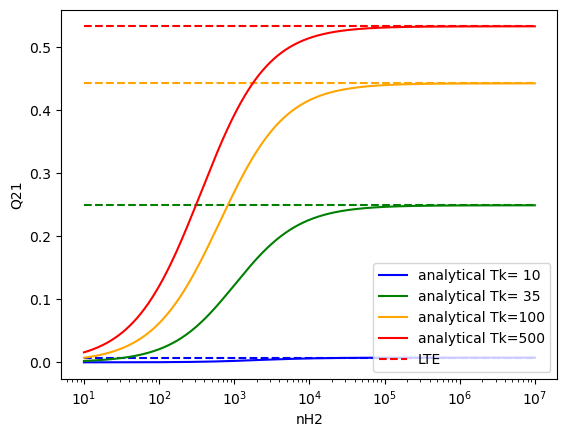

In [14]:
nH2s=np.logspace(1,7,1000)
def Qul_compare(Td):
    Q10_anl,Q21_anl=np.zeros_like(nH2s),np.zeros_like(nH2s)
    Q10_LTE,Q21_LTE=np.zeros_like(nH2s),np.zeros_like(nH2s)
    for i in range(len(nH2s)):
        nH2=nH2s[i]
        npH2=nH2/(1+opH2_ratio)
        noH2=nH2*opH2_ratio/(1+opH2_ratio)
        Kp,n0_nci_Kp,n1_nci_Kp,n2_nci_Kp=compute_population(Td,nH2,'pH2')
        Ko,n0_nci_Ko,n1_nci_Ko,n2_nci_Ko=compute_population(Td,nH2,'oH2')
        n0_nci,n1_nci,n2_nci=np.array([n0_nci_Kp,n1_nci_Kp,n2_nci_Kp])/Kp/(1+opH2_ratio)+np.array([n0_nci_Ko,n1_nci_Ko,n2_nci_Ko])/Ko*opH2_ratio/(1+opH2_ratio)
        Q21_anl[i],Q10_anl[i]=n2_nci,n1_nci

        Tex=Td
        A10,A21=ci_mol.rad_data[:2,2]
        v10,v21=ci_mol.rad_data[:2,3]
        Qrot=1+3*np.exp(-23.6/Tex)+5*np.exp(-62.5/Tex)
        Q10_LTE[i]=3*np.exp(-23.6/Tex)/Qrot
        Q21_LTE[i]=5*np.exp(-62.5/Tex)/Qrot
    return Q10_anl,Q21_anl,Q10_LTE,Q21_LTE
Td=10
Q10_anl,Q21_anl,Q10_LTE,Q21_LTE=Qul_compare(Td)
plt.plot(nH2s,Q21_anl,'b-',label='analytical Tk=%3.0f'%Td)
plt.plot(nH2s,Q21_LTE,'b--')
Td=35
Q10_anl,Q21_anl,Q10_LTE,Q21_LTE=Qul_compare(Td)
plt.plot(nH2s,Q21_anl,'g-',label='analytical Tk=%3.0f'%Td)
plt.plot(nH2s,Q21_LTE,'g--')
Td=100
Q10_anl,Q21_anl,Q10_LTE,Q21_LTE=Qul_compare(Td)
plt.plot(nH2s,Q21_anl,'-',c='orange',label='analytical Tk=%3.0f'%Td)
plt.plot(nH2s,Q21_LTE,'--',c='orange')
Td=500
Q10_anl,Q21_anl,Q10_LTE,Q21_LTE=Qul_compare(Td)
plt.plot(nH2s,Q21_anl,'r-',label='analytical Tk=%3.0f'%Td)
plt.plot(nH2s,Q21_LTE,'r--',label='LTE')
plt.legend(loc='lower right')
plt.xscale('log')
plt.ylabel('Q21')
plt.xlabel('nH2')
plt.savefig('plots/CI_comparison/Q21_nH2.pdf')

In [15]:
Q10_anl,Q21_anl,Q10_LTE,Q21_LTE=Qul_compare(Td)

In [16]:
os.system('pdfunite plots/CI_comparison/Q21* plots/Q21_nH2.pdf')

0

### compare masses ###

(array([79.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.53288726e-02, 5.49635054e+00, 1.09573722e+01, 1.64183939e+01,
        2.18794156e+01, 2.73404372e+01, 3.28014589e+01, 3.82624806e+01,
        4.37235022e+01, 4.91845239e+01, 5.46455456e+01]),
 <BarContainer object of 10 artists>)

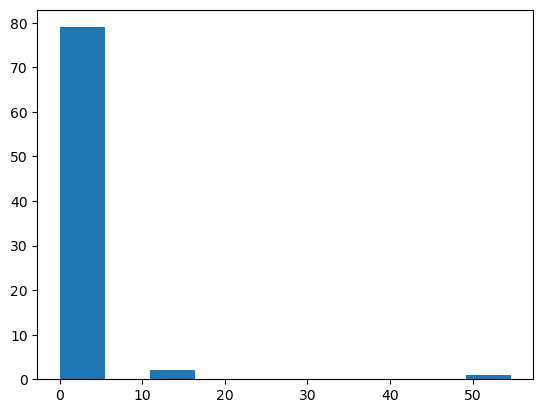

In [17]:
dis_alphaCO=alphaCO/10**(lg_MCO10[:,0]-lg_MCOLVG[:,0])
plt.hist(dis_alphaCO)

In [18]:
def draw_relation(xx,yy,xname,yname):
    fig, ax = plt.subplots(figsize=[6,6])
    data=np.concatenate([xx,yy],axis=1)
    rm_nan=~np.isnan(data).any(axis=1)
    rm_SN1=data[:,1]<1/np.log(10)/2
    rm_SN2=data[:,3]<1/np.log(10)/2
    data=data[rm_nan*rm_SN1*rm_SN2]
    plt.errorbar(data[:,0],data[:,2],xerr=data[:,1],yerr=data[:,3],fmt="o", ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
    minx,miny=np.nanmin(data[:,0]-data[:,1]),np.nanmin(data[:,2]-data[:,3])
    maxx,maxy=np.nanmax(data[:,0]+data[:,1]),np.nanmax(data[:,2]+data[:,3])
    x=np.linspace(5,14,100)
    plt.plot(x,x,'--g',lw=1,label='linear guideline')
    plt.legend(fontsize=12)
    plt.xlim([np.nanmin([minx,miny])-0.1,np.nanmax([maxx,maxy])+0.1])
    plt.ylim([np.nanmin([minx,miny])-0.1,np.nanmax([maxx,maxy])+0.1])
    plt.xlabel(r'log $M_{\rm gas}$('+xname+r') [$\rm M_{\odot}$]',fontsize=12)
    plt.ylabel(r'log $M_{\rm gas}$('+yname+r') [$\rm M_{\odot}$]',fontsize=12)
    plt.savefig('plots/relation/gas_mass_%s_%s.pdf'%(xname.replace(' ',''),yname.replace(' ','')))

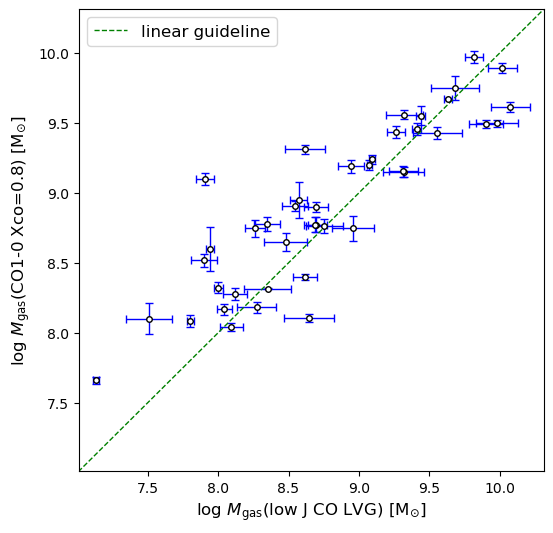

In [19]:
draw_relation(lg_MCOLVG,lg_MCO10,'low J CO LVG','CO1-0 Xco=%3.1f'%(alphaCO))

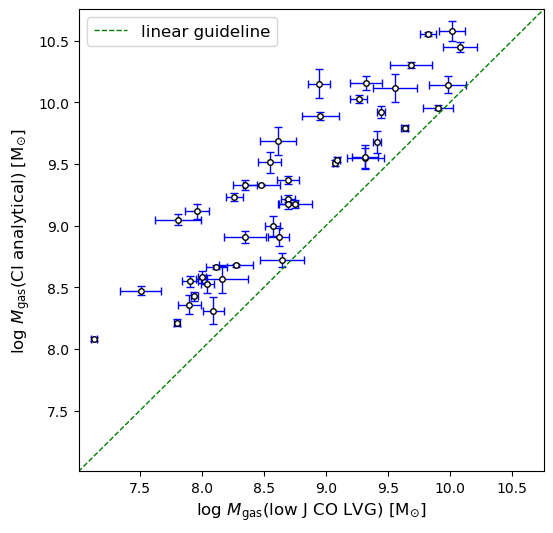

In [20]:
draw_relation(lg_MCOLVG,lg_MCInLTEP,'low J CO LVG','CI analytical')

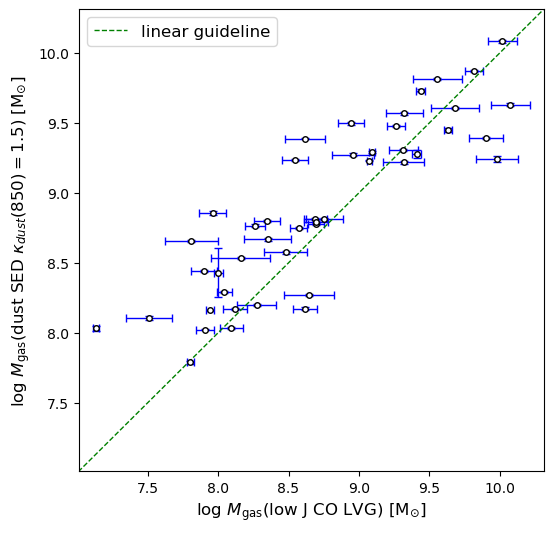

In [21]:
draw_relation(lg_MCOLVG,lg_MSEDKgas,'low J CO LVG','dust SED $\kappa_{dust}(850)=1.5$')

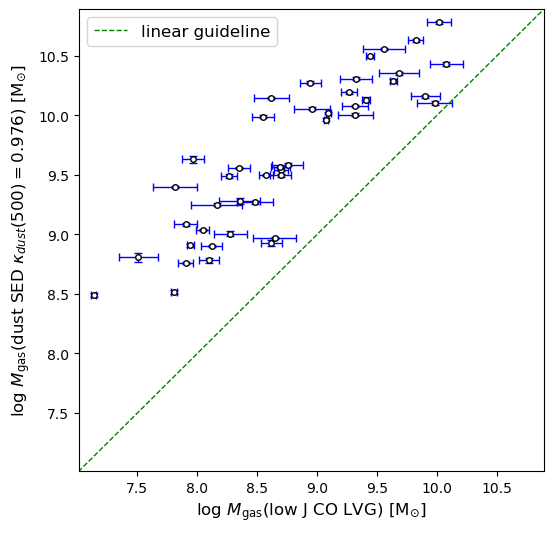

In [22]:
draw_relation(lg_MCOLVG,lg_MSEDDgas,'low J CO LVG','dust SED $\kappa_{dust}(500)=0.976$')

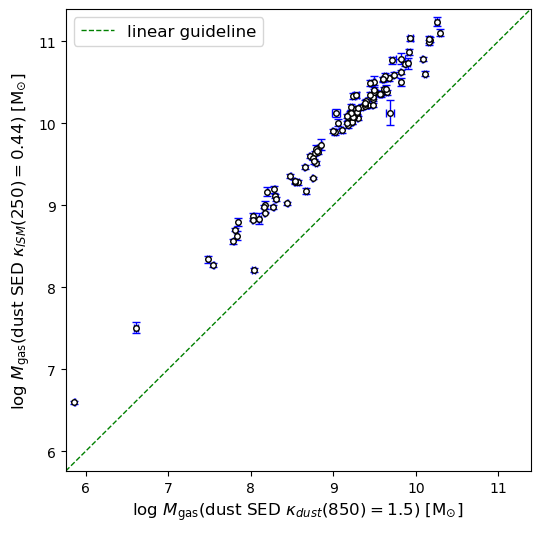

In [23]:
draw_relation(lg_MSEDKgas,lg_MSEDPISM,'dust SED $\kappa_{dust}(850)=1.5$','dust SED $\kappa_{ISM}(250)=0.44$')

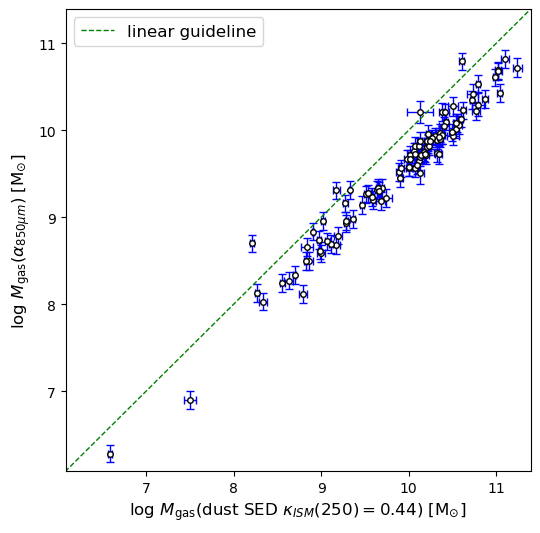

In [24]:
draw_relation(lg_MSEDPISM,lg_Malp850S,'dust SED $\kappa_{ISM}(250)=0.44$',r'$\alpha_{850\mu m}$')

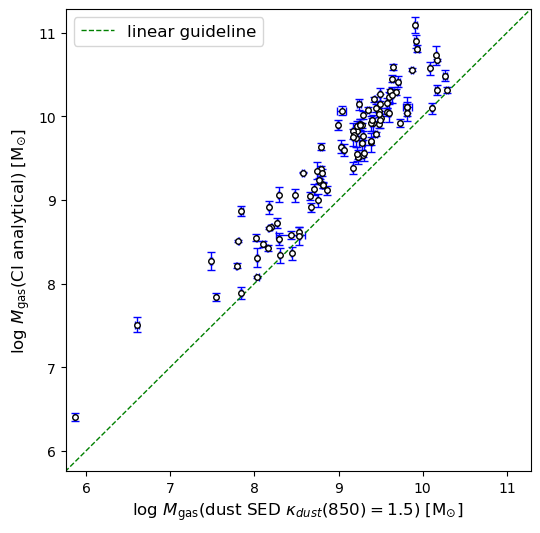

In [25]:
draw_relation(lg_MSEDKgas,lg_MCInLTEP,'dust SED $\kappa_{dust}(850)=1.5$','CI analytical')

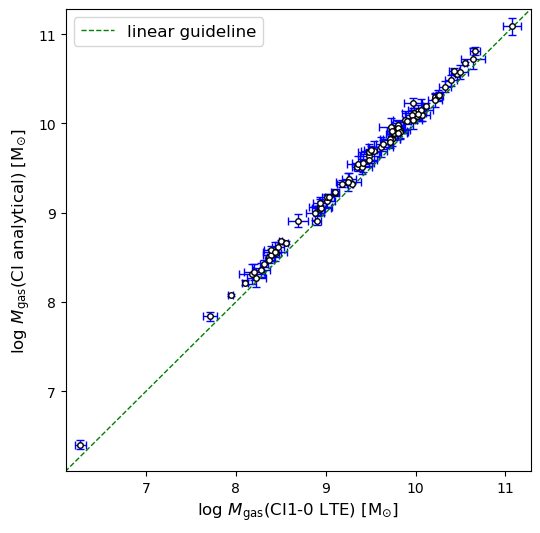

In [26]:
draw_relation(lg_MCILTEW,lg_MCInLTEP,'CI1-0 LTE','CI analytical')

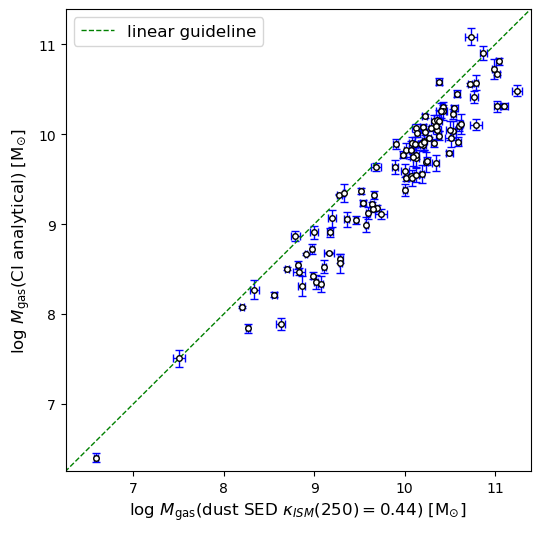

In [27]:
draw_relation(lg_MSEDPISM,lg_MCInLTEP,'dust SED $\kappa_{ISM}(250)=0.44$','CI analytical')

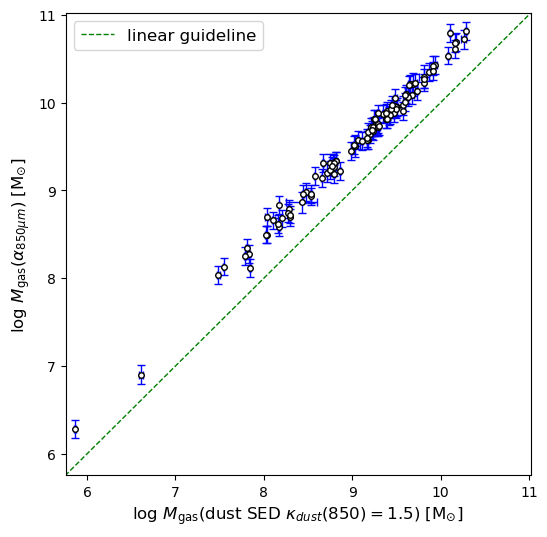

In [28]:
draw_relation(lg_MSEDKgas,lg_Malp850S,'dust SED $\kappa_{dust}(850)=1.5$',r'$\alpha_{850\mu m}$')

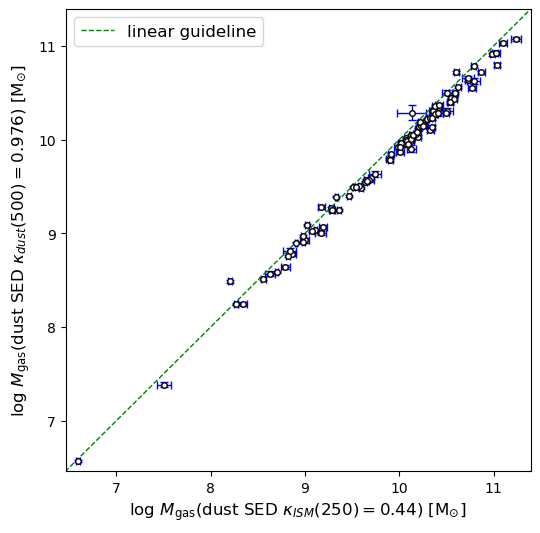

In [29]:
draw_relation(lg_MSEDPISM,lg_MSEDDgas,'dust SED $\kappa_{ISM}(250)=0.44$','dust SED $\kappa_{dust}(500)=0.976$')

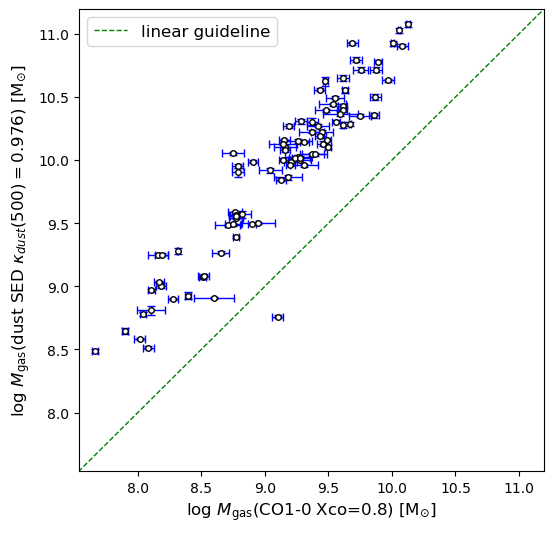

In [30]:
draw_relation(lg_MCO10,lg_MSEDDgas,'CO1-0 Xco=%3.1f'%(alphaCO),'dust SED $\kappa_{dust}(500)=0.976$')

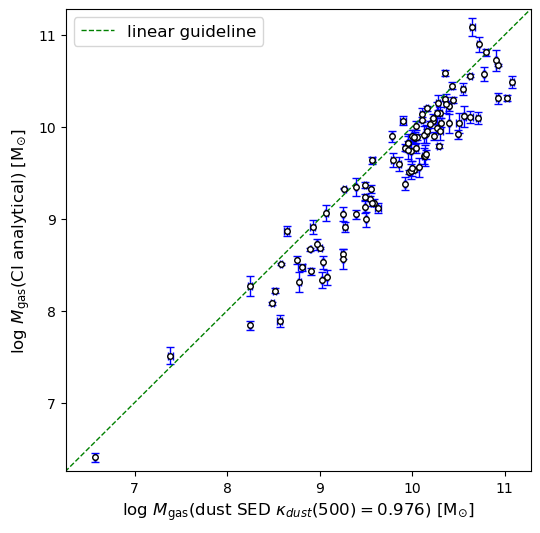

In [31]:
draw_relation(lg_MSEDDgas,lg_MCInLTEP,'dust SED $\kappa_{dust}(500)=0.976$','CI analytical')

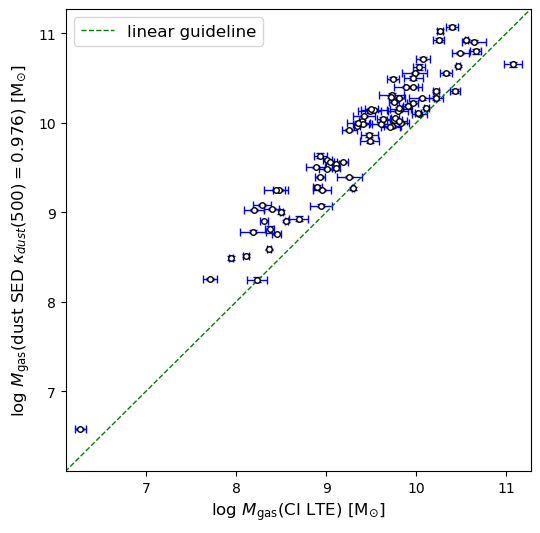

In [32]:
draw_relation(lg_MCILTEW,lg_MSEDDgas,'CI LTE','dust SED $\kappa_{dust}(500)=0.976$')

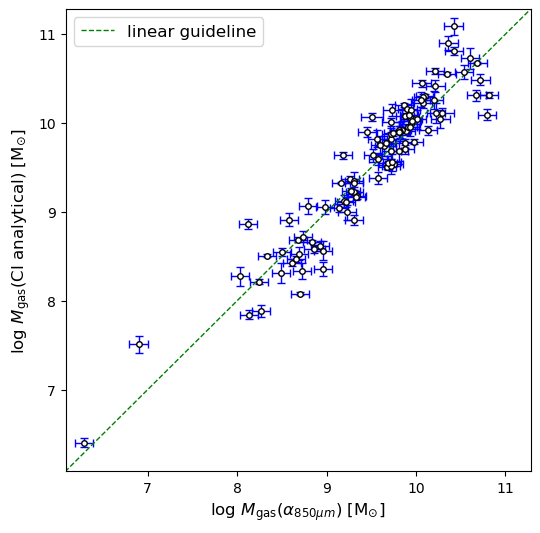

In [33]:
draw_relation(lg_Malp850S,lg_MCInLTEP,r'$\alpha_{850\mu m}$','CI analytical')

In [34]:
def alphaCO_benchmark(lg_MCO,lg_Mcal,aCOasm):
    data=np.concatenate([lg_MCO,lg_Mcal],axis=1)
    rm_nan=~np.isnan(data).any(axis=1)
    rm_SN=data[:,3]<1/np.log(10)/3
    data=data[rm_nan*rm_SN]
    aCOcal=10**np.mean(data[:,2]-data[:,0])*aCOasm
    err_mea=np.sqrt(np.sum(data[:,1]**2+data[:,3]**2))/len(data)*aCOcal*np.log(10)
    err_dis=np.std(data[:,2]-data[:,0])*aCOcal*np.log(10)
    error=np.sqrt(err_mea**2+err_dis**2)
    return aCOcal,error
alphaCO_benchmark(lg_MCO10,lg_MSEDPISM,alphaCO)

(6.0627491868210726, 3.6089387958347805)

In [35]:
tracers={'CO10':lg_MCO10,
        'COLVG':lg_MCOLVG,
        'CI_analytic':lg_MCInLTEP,
        'CI_LTE':lg_MCILTEW,
        'dustkK':lg_MSEDKgas,
        'dustkD':lg_MSEDDgas,
        'dustkP':lg_MSEDPISM,
        'alpha850':lg_Malp850S}
print(len(tracers))
for name in tracers.keys():
    print(alphaCO_benchmark(lg_MCO10,tracers[name],alphaCO))

8
(0.8, 0.017150697422519356)
(0.5328537053617904, 0.38829021743787595)
(2.8002697793779676, 2.1005098433760416)
(1.9409166954206274, 1.504296383840894)
(0.8840429892693256, 0.48322833236158963)
(4.994777185721333, 2.7307894794037755)
(6.0627491868210726, 3.6089387958347805)
(2.6780191533307782, 1.5115965136239866)


In [36]:
from astropy.coordinates import SkyCoord
import astropy.units as u
RBGS_basic=np.loadtxt('references/RBGS.csv',delimiter=',',dtype=str)
idx_in_RBGS=np.zeros(len(basic_info)-1)
idx_in_RBGS[:]=np.nan
sample_cor,RBGS_cor=[],[]
for i in range(1,len(basic_info)):
    ra,dec=basic_info[i,1:3]
    sample_cor.append(SkyCoord(ra,dec,frame="icrs",unit=(u.hourangle, u.deg)))
for i in range(len(RBGS_basic)):
    ra=RBGS_basic[i,4].strip().replace(' ',':')
    dec=RBGS_basic[i,5].strip().replace(' ',':')
    RBGS_cor.append(SkyCoord(ra,dec,frame="icrs",unit=(u.hourangle, u.deg))) 
for i in range(1,len(basic_info)):
    targcor=sample_cor[i-1]
    sep=np.zeros(len(RBGS_basic))
    for j in range(len(RBGS_basic)):
        sep[j]=targcor.separation(RBGS_cor[j]).deg
    idx=np.argmin(sep)
    if sep[idx]<1/60:
        idx_in_RBGS[i-1]=idx
lg_LTIR=np.zeros(len(idx_in_RBGS))
for i in range(len(idx_in_RBGS)):
    if not np.isnan(idx_in_RBGS[i]):
        idx=int(idx_in_RBGS[i])
        dist_RBGS=float(RBGS_basic[idx,22])
        TIR_RBGS=float(RBGS_basic[idx,25].replace(':',''))
        lg_LTIR[i]=TIR_RBGS-np.log10(dist_RBGS**2)+np.log10(read_distance(basic_info[i+1,0])**2)
lg_LTIR[lg_LTIR==0]=np.nan

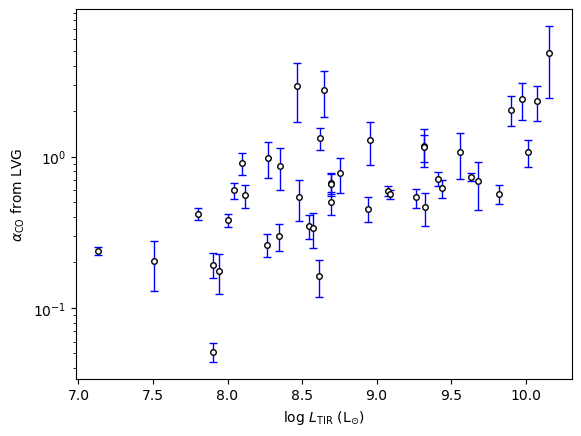

In [37]:
aCOcor=10**(lg_MCOLVG[:,0]-lg_MCO10[:,0])*alphaCO
aCOcorerr=np.sqrt(lg_MCOLVG[:,1]**2+lg_MCO10[:,1]**2)*aCOcor*np.log(10)*alphaCO
aCOcor[aCOcor/aCOcorerr<2]=np.nan
plt.errorbar(lg_MCOLVG[:,0],aCOcor,yerr=aCOcorerr,fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
#for i in range(len(basic_info)-1):
#    plt.text(lg_LTIR[i],aCOcor[i],basic_info[i+1,0])
plt.yscale('log')
plt.xlabel(r'log $L_{\rm TIR}~\rm (L_{\odot})$')
plt.ylabel(r'$\alpha_{\rm CO}$ from LVG')
plt.savefig('plots/sample_dist/TIR_alphaCOLVG.pdf')

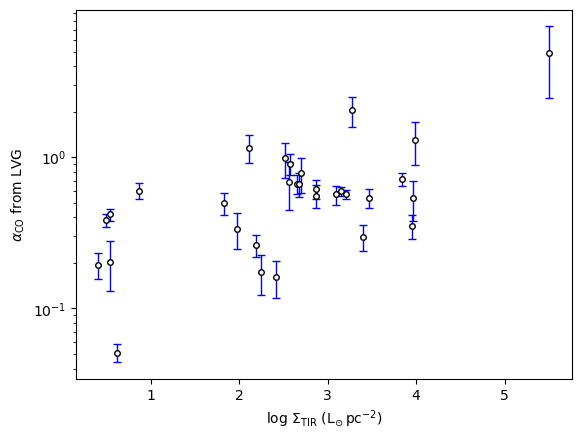

In [38]:
idx=np.where(basic_info[0]=='Size/arcsec')[0][0]
Diameter=basic_info[1:,idx].astype(float)
idx=np.where(basic_info[0]=='Distance')[0][0]
Distance=basic_info[1:,idx].astype(float)
size=Diameter*Distance*1e6*np.pi/180/3600
area=np.pi*size**2 /2
lg_SigmaMLVG=lg_MSEDDdust[:,0]-np.log10(area)
plt.errorbar(lg_SigmaMLVG,aCOcor,yerr=aCOcorerr,fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
plt.yscale('log')
#for i in range(len(basic_info)-1):
#    plt.text(lg_SigmaTIR[i],aCOcor[i],basic_info[i+1,0],fontsize=8)
plt.xlabel(r'log $\Sigma_{\rm TIR}~\rm (L_{\odot}\,pc^{-2})$')
plt.ylabel(r'$\alpha_{\rm CO}$ from LVG')
plt.savefig('plots/sample_dist/SigmaTIR_alphaCOLVG.pdf')
def draw_relation(xx,yy,xname,yname):
    fig, ax = plt.subplots(figsize=[7,6])
    for i in range(len(xx)):
        if xx[i,1]<.47 and yy[i,1]<.47:
            plt.errorbar(xx[i,0],yy[i,0],xerr=xx[i,1],yerr=yy[i,1],fmt="o", ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
    minx,miny=np.nanmin(xx[:,0]-xx[:,1]),np.nanmin(yy[:,0]-yy[:,1])
    maxx,maxy=np.nanmax(xx[:,0]+xx[:,1]),np.nanmax(yy[:,0]+yy[:,1])
    x=np.array([1,2,5])
    y=np.array([np.log10(4.6),np.log10(4.6),np.log10(4.6)-1.5])
    plt.plot(x,y,'-g',label='fit from Bolatto et al. 2013',lw=4)
    plt.legend(fontsize=13)
    #for i in range(len(sourcenames)):
    #    plt.text(xx[i,0], yy[i,0], sourcenames[i], fontsize=8)
    #plt.xlim([np.nanmin([minx,miny])-0.3,np.nanmax([maxx,maxy])+0.3])
    #plt.ylim([np.nanmin([minx,miny])-0.3,np.nanmax([maxx,maxy])+0.3])
    #plt.fill_between(x,np.log10(0.3),np.log10(1.3))
    plt.xlim([1,5])
    plt.ylim([-1,2])
    plt.xlabel(r'log Total Surface Density from dust [$\rm M_{\odot}\,pc^{-2}$]',fontsize=13)
    plt.ylabel(r'log $X_{\rm CO}$ [$\rm M_{\rm \odot}\,pc^{-2}\,(K\,km\,s^{-1})^{-1}$]',fontsize=13)
    plt.savefig('gas_mass_%s_%s.pdf'%(xname,yname))
    

/home/zj/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/zj/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/zj/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/zj/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


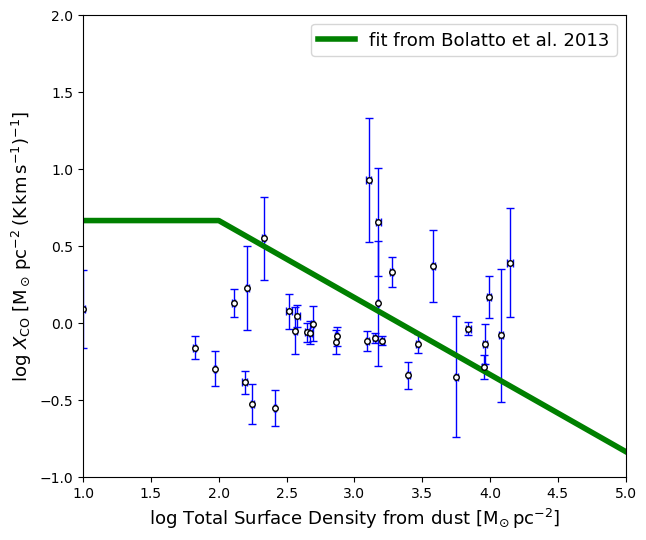

In [39]:
lg_alphaCO=np.zeros_like(lg_MCOLVG)
lg_alphaCO[:,0]=(lg_MCOLVG[:,0]-lg_MCO10[:,0])*alphaCO
lg_alphaCO[:,1]=np.sqrt(lg_MCOLVG[:,1]**2+lg_MCO10[:,1]**2)*alphaCO
lg_SigmaMLVG=np.zeros_like(lg_MCOLVG)
lg_SigmaMLVG[:,0]=lg_MSEDDdust[:,0]-np.log10(area)
lg_SigmaMLVG[:,1]=lg_MSEDDdust[:,1]
draw_relation(lg_SigmaMLVG,lg_alphaCO,'gas mass density','CO conversion factor')

In [40]:
alphaCOLVG=np.zeros([len(basic_info)-1,2])
alphaCOLVG[:]=np.nan
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    sampfile='MCMC_samples/CO_SLED/%s_samples.h5'%sourcename.replace(' ','')
    if os.path.isfile(sampfile):
        sampler = emcee.backends.HDFBackend(sampfile, read_only=True)
        samples=sampler.get_chain(discard=7000)
        log_prob_samples = sampler.get_log_prob(discard=7000)
        sample_reshape=samples.reshape(samples.shape[0]*samples.shape[1],samples.shape[2])
        max_index=np.argmax(log_prob_samples)
        params=sample_reshape[max_index]
        Tkin,nH2,Kvir,size=10**params
        Tbs=run_myradex_of(Tkin=Tkin,nH2=nH2,abundance_Kvir=1e-4/Kvir,molecule=co_mol,Tbg=2.73)[0]
        alphaCOLVG[i-1,0]=2.65*nH2**0.5/Tbs[0]/Kvir
        Xco_pdf=np.load('MCMC_samples/CO_SLED/%s_Xco.npy'%sourcename.replace(' ','')).reshape(20000,20)[7000:]
        lg_Xco=best_fitting(np.log10(Xco_pdf.reshape(Xco_pdf.shape[0]*Xco_pdf.shape[1])))
        lg_Xco_err=(lg_Xco[2]-lg_Xco[1])/2
        alphaCOLVG[i-1,1]=alphaCOLVG[i-1,0]*np.log(10)*lg_Xco_err
        if lg_Xco_err>1/np.log(10):
            alphaCOLVG[i-1]=np.nan

In [41]:
idx=np.where(basic_info[0]=='Size/arcsec')[0][0]
Diameter=basic_info[1:,idx].astype(float)
idx=np.where(basic_info[0]=='Distance')[0][0]
Distance=basic_info[1:,idx].astype(float)
size=Diameter*Distance*1e6*np.pi/180/3600
area=np.pi*size**2 /2
lg_SigmaTIR=lg_LTIR-np.log10(area)

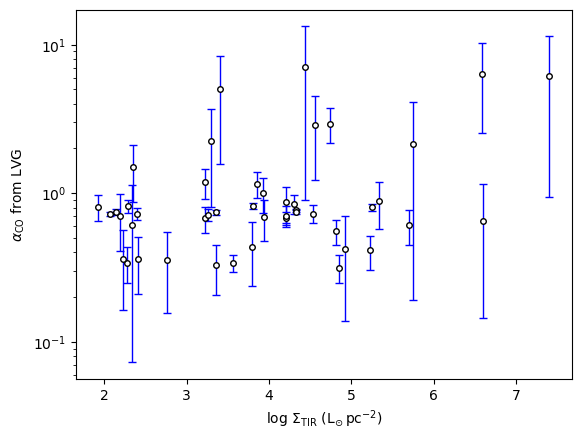

In [42]:
plt.errorbar(lg_SigmaTIR,alphaCOLVG[:,0],yerr=alphaCOLVG[:,1],fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
plt.yscale('log')
#for i in range(len(basic_info)-1):
#    plt.text(lg_SigmaTIR[i],alphaCOLVG[i,0],basic_info[i+1,0],fontsize=8)
plt.xlabel(r'log $\Sigma_{\rm TIR}~\rm (L_{\odot}\,pc^{-2})$')
plt.ylabel(r'$\alpha_{\rm CO}$ from LVG')
#plt.ylim(0.1,100)
plt.savefig('plots/sample_dist/SigmaTIR_alphaCOLVG.pdf')

(array([44.,  7.,  3.,  7.,  0.,  0.,  1.,  0.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.28861196,  1.02223692,  1.75586187,  2.48948682,  3.22311178,
         3.95673673,  4.69036168,  5.42398664,  6.15761159,  6.89123655,
         7.6248615 ,  8.35848645,  9.09211141,  9.82573636, 10.55936131,
        11.29298627, 12.02661122, 12.76023618, 13.49386113, 14.22748608,
        14.96111104]),
 <BarContainer object of 20 artists>)

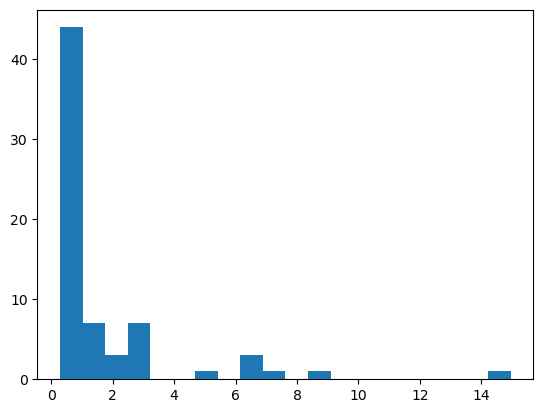

In [43]:
plt.hist(alphaCOLVG[:,0],bins=20)

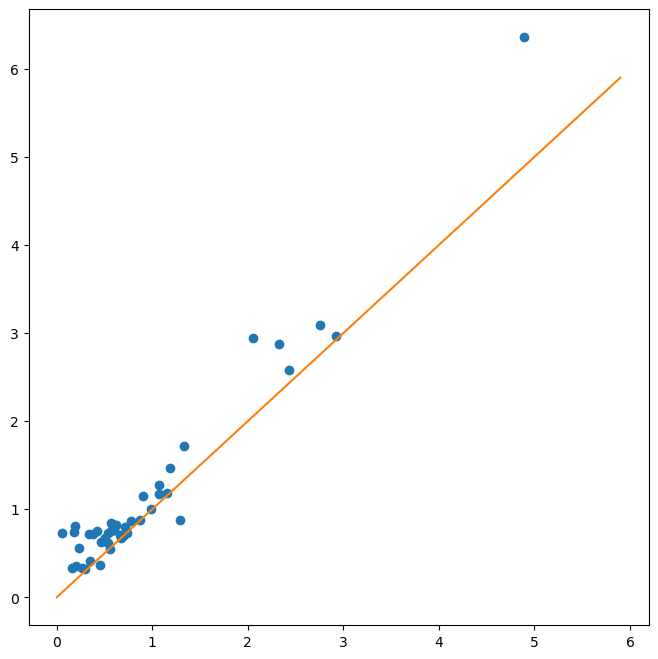

In [44]:
plt.figure(figsize=[8,8])
plt.plot(aCOcor,alphaCOLVG[:,0],'o')
plt.plot(np.arange(0,6,0.1),np.arange(0,6,0.1))

In [45]:
sampler = emcee.backends.HDFBackend('MCMC_samples/CO_SLED/NGC5194_samples.h5', read_only=True)
samples=sampler.get_chain(discard=7000)
log_prob_samples = sampler.get_log_prob(discard=7000)
sample_reshape=samples.reshape(samples.shape[0]*samples.shape[1],samples.shape[2])
max_index=np.argmax(log_prob_samples)
params=sample_reshape[max_index]
params

array([1.35344277, 2.00003613, 0.30898357, 2.17894106])

In [46]:
param_mass(*params)

5.392216424276166

In [47]:
sourcename='NGC5194'
data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
distance=read_distance(sourcename)
redshift=read_redshift(sourcename)
CO_SLED=load_mol('CO Jup',data)
CO_Jup=CO_SLED[:,0].astype(int)
detJ=CO_Jup[~np.isnan(CO_SLED).any(axis=1)]
 
lum=line_flux_lum(CO_SLED[:,1:3],co_mol.rad_data[CO_Jup-1,3],redshift,distance)
lg_MCO10[i-1]=log_value(lum[min(detJ)-1]*alphaCO)
lum

array([[2.62747162e+08, 2.45033870e+07],
       [2.62759483e+08, 1.97807701e+07],
       [2.31605270e+08, 3.54297013e+07],
       [2.89741948e+07, 4.70599979e+06],
       [2.27982230e+07, 3.01220045e+06],
       [1.08295492e+07, 1.23063060e+06],
       [5.32931783e+06, 6.33007208e+05],
       [           nan, 3.37469204e+06],
       [           nan, 6.38471898e+06],
       [           nan, 5.35027293e+06],
       [           nan, 3.00560282e+06],
       [           nan, 2.09496111e+06],
       [           nan, 3.30866282e+06]])

In [48]:
np.nanmean(alphaCOLVG[:,0])

1.741257214421664